<a href="https://colab.research.google.com/github/vansh-31/ML-Projects/blob/main/LipNet/LipNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [1]:
!pip install imageio==2.23.0 opencv-python==4.6.0.66 dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6


In [2]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import os
import cv2
import dlib
from imutils import face_utils
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd "/content/drive/MyDrive/ML Projects/LipNet"

/content/drive/MyDrive/ML Projects/LipNet


# 1. Build Data Loading Functions

In [11]:
#@title This function will use the dlib library's pretrained model to detect 68 facial landmark and will extract the lips video (grayscaled)
def load_video(path:str) -> List[float]:
    # Load the dlib pretrained model for lips extraction
    p = "/content/drive/MyDrive/ML Projects/LipNet/shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(p)

    # Load the Video
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        # Get the frame
        ret, frame = cap.read()

        # get the maximum bounds of the frame
        Y_MAX,X_MAX,_ = frame.shape

        # Convert the frame in grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # pick some default values if face not found
        x_min = 80
        x_max = 220
        y_min = 190
        y_max = 236

        # detect faces in the grayscale image
        shape = detector(frame, 0)
        if len(shape)>0:
            shape = shape[0]
            shape = predictor(frame, shape)
            shape = face_utils.shape_to_np(shape)
            lips = shape[48:68]
            # Finding minimum and maximum values to extract a reactagle frame containing only lips
            x_min = max(0,np.min(lips[:, 0]) - 30)
            x_max = min(X_MAX-1,np.max(lips[:, 0]) + 30)
            y_min = max(0,np.min(lips[:, 1]) - 10)
            y_max = min(Y_MAX-1, np.max(lips[:, 1]) + 10)

        # Visualization
        # cv2.circle(frame, (x_min, y_min), 2, (0, 255, 0), -1)
        # cv2.circle(frame, (x_max, y_min), 2, (0, 255, 0), -1)
        # cv2.circle(frame, (x_max, y_max), 2, (0, 255, 0), -1)
        # cv2.circle(frame, (x_min, y_max), 2, (0, 255, 0), -1)
        # [ Y_min:Y_maxm X_min:X_max ]
        frame = frame[ y_min:y_max, x_min:x_max]

        # print( "Width: ",min(X_MAX-1,x_max+10)-max(0,x_min-10),"Height: ", min(Y_MAX-1,y_max+10)-max(0,y_min-10) )

        # Resize each frame so that it can be used with Neural Networks
        frame = cv2.resize(np.array(frame), (140, 46), interpolation=cv2.INTER_LINEAR)

        frame = tf.expand_dims(frame,axis=-1)

        # Append the Resized frame in our frames list
        frames.append( frame )
    cap.release()
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) # Standardize the video for faster Processing
    return tf.cast((frames - mean), tf.float32) / std

TensorShape([75, 46, 140, 1])

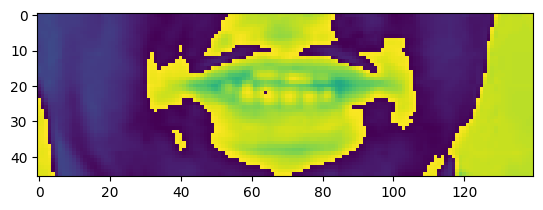

In [13]:
plt.imshow(load_video('/content/drive/MyDrive/ML Projects/LipNet/data/s1/bbal6n.mpg')[40])
load_video('/content/drive/MyDrive/ML Projects/LipNet/data/s1/bbal6n.mpg').shape

In [14]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num(['m','i','t','s'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([13,  9, 20, 19])>

In [ ]:
num_to_char([13,  9,  20, 19])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'm', b'i', b't', b's'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)) )[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [ ]:
test_path = '/content/drive/MyDrive/ML Projects/LipNet/data/s1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

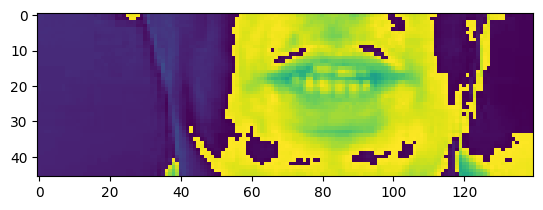

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/ML Projects/LipNet/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(train), len(test)

(450, 51)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next();

In [ ]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

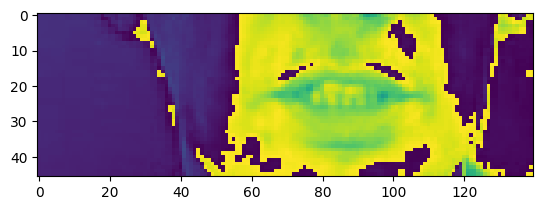

In [ ]:
# 0 : 1st batch of the videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red with g six now'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
5*17*75

6375

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'qqqqqqqqqqqqqq777777777qqqqq777777777qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq77777a'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'qqqqqqqqqqqqqq777777777qqqqq777777777qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq77777a'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

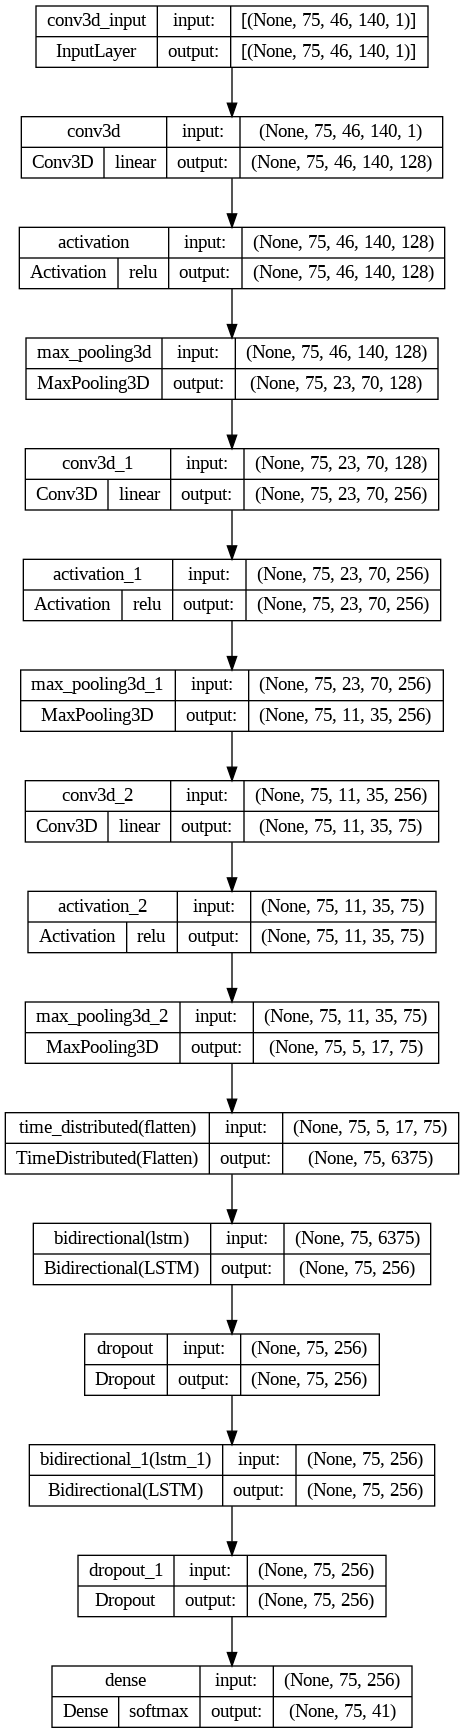

In [ ]:
plot_model(model,show_shapes=True,show_layer_activations=True)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
# CTC: Connectionist Temporal Classification
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('model','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction

In [ ]:
!ls

animation.gif  data  LipNet.ipynb  model  model.png


In [ ]:
model.load_weights('./model/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_vids = []
test_texts = []
for frames,alignments in test_data:
    test_vids.append(frames)
    test_texts.append(alignments)

In [ ]:
test_vids = np.array(test_vids)
test_texts = np.array(test_texts)
test_vids.shape, test_texts.shape

((50, 2, 75, 46, 140, 1), (50, 2, 40))

In [ ]:
def predict_and_compare(model,video,text):
    if video.ndim == 4 and text.ndim == 1:
        pred = tf.squeeze(model.predict(tf.expand_dims(video,axis=0)))
        real_text = [tf.strings.reduce_join([num_to_char(word) for word in text])]
        decoded = tf.keras.backend.ctc_decode([pred,pred], input_length=[75,75], greedy=True)[0][0].numpy()
        pred_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0]
        return (real_text,pred_text)
    elif video.ndim == 5 and text.ndim == 2 and video.shape[0] == 2 and text.shape[0] == 2:
        pred = model.predict(video)
        real_texts = []
        for sentence in text:
            real_texts.append([tf.strings.reduce_join([num_to_char(word) for word in sentence])])
        decoded = tf.keras.backend.ctc_decode(pred, input_length=[75,75], greedy=True)[0][0].numpy()
        pred_texts = []
        for sentence in decoded:
            pred_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence])]
            pred_texts.append(pred_text)
        return (real_texts,pred_texts)
    else:
        raise ValueError("Input Dimensions do not match (Expected Batch size is 2)")

In [ ]:
real_texts,pred_texts = predict_and_compare(model,test_vids[49],test_texts[49])
print('~'*100, 'REAL TEXT')
print(real_texts)
print('~'*100, 'PREDICTIONS')
print(pred_texts)

1/1 [==============================] - 2s 2s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[[<tf.Tensor: shape=(), dtype=string, numpy=b'place green at q six now'>], [<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in r nine again'>]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[[<tf.Tensor: shape=(), dtype=string, numpy=b'place green at q six now'>], [<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in r nine again'>]]


# Evaluate the Model.
### We will evaluate our model baed on Average Word Accuracy.

In [ ]:
def wordAccuracy(realText,predText):
    realText = realText.decode().split(" ")
    predText = predText.decode().split(" ")
    n,m = len(realText),len(predText)
    total = n
    correct = -abs(n-m)
    for i in range(min(n,m)):
        correct += realText[i] == predText[i]
    return correct/total

In [ ]:
avgWordAccuracy = 0
for index in range(50):
    real_texts,pred_texts = predict_and_compare(model,test_vids[index],test_texts[index])
    real_text1,real_text2 = real_texts[0][0].numpy(),real_texts[1][0].numpy()
    pred_text1,pred_text2 = pred_texts[0][0].numpy(),pred_texts[1][0].numpy()
    avgWordAccuracy += wordAccuracy(real_text1,pred_text1)
    avgWordAccuracy += wordAccuracy(real_text2,pred_text2)

1/1 [==============================] - 0s 177ms/step


In [ ]:
print(avgWordAccuracy)

91.2142857142857


# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]